<a href="https://colab.research.google.com/github/AhmetCannnn/image_processing_with_deep_learning/blob/main/airline_passenger_number_estimation_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab  Bağlantısının Yapılması

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# RNN ile Havayolu Yolcu Sayısı Tahmini



1.   İş Problemi(Business Porblem)
2.   Veriyi Anlamak(Data Understanding)
3.   Veriyi Hazırlamak(Data Preparation)
4.   Modelleme(Modeling)
5.   Değerlendirme(Evaluation)




# İş Problemi (Business Problem)



*   **Month:** Aylık olarakyer alan tarih değişkeni.
*   **Passengers:** İlgili işlem tarihindeki yolcu sayısını, yani aylık yolcu sayısını temsil etmektedir.


https://www.kaggle.com/datasets/andreazzini/international-airline-passengers


# 2) Veriyi Anlamak(Data Understanding)

**2.1)Gerekli Kütüphanelerin import işlemi**


In [41]:
# Veriyi okuma ve işleme adımında kullanılacak kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan küütphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmakiçin kullanılacak kütüphaneler
import warnings
warnings.filterwarnings('ignore')

# Tensorflow warning engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**2.2)Veri setinin yüklenmesive verinin genel resminin incelenmesi**

In [42]:
df = pd.read_csv('/content/drive/MyDrive/international-airline-passengers.csv') # pandas kütüphanesini kullanarak googgle drive'daki csv dosyasını okumak
df.head() # ilk 5 satırı gösterir

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [43]:
df.columns # veri setinin sütunlarını gösterir

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [44]:
df.columns = ['Month', 'Passengers'] # veri setinin sütunlarını değiştirir

In [45]:
df.head() # ilk 5 satırı tekrar gösterdik

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [46]:
df.tail() # veri setinin son 5 satırını gösterir

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


 **Burdaki son satırdaki gözlemi istemiyoruz çünkü bu problemli bir gözlem**

In [47]:
df.shape # veri setinin satır ve sütun sayısını gösterir

(145, 2)

In [48]:
df.dtypes # veri setinin sütunların veri tiplerini gösterir

,0
Month,object
Passengers,float64


 **Ay değişkeninin tarih değişkeni olması gerekireken object  değişkeni halindedir değişken tipinin değiştirilmesi gerekmektedir**

In [51]:
df.isnull().sum() # veri setindeki eksik değerlerin sayısını gösterir

,0
Month,0
Passengers,1


In [52]:
df.describe().T # veri setinin istatistiksel özelliklerini gösterir

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


**144 ayda ortalama 280 yolcu, minimum 104, maximum 622 yolcu seyehat etmiştir**


# **3) Veriyi hazırlamak(Data Preparation)**

In [53]:
df = df[:144] # en sondaki hatalı satırı veri setimize dahil etmeme kodu

In [54]:
df.tail() # kontrol

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [55]:
df.info() # veri setinin genel bilgilerini gösterir

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [57]:
df['Month'] = pd.to_datetime(df['Month']) # ay değişkenini tarih değişkenine dönüştürür

In [58]:
df.info() # kontrol

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [59]:
print("Maximin tarih:", df['Month'].min()) # veri setindeki en küçük tarih
print("Minimum tarih:", df['Month'].max()) # veri setindeki en büyük tarih

Maximin tarih: 1949-01-01 00:00:00
Minimum tarih: 1960-12-01 00:00:00


In [60]:
df.index = df['Month'] # ay değişkenini index olarak belirler

In [61]:
df.head() # kontrol

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [62]:
df.drop('Month', axis=1, inplace=True) # ay değişkenini veri setinden çıkarır çünkü ay değişken, artık index durumunda

In [63]:
df.head() # kontrol

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [64]:
result_df = df.copy() # veri setini kopyalar

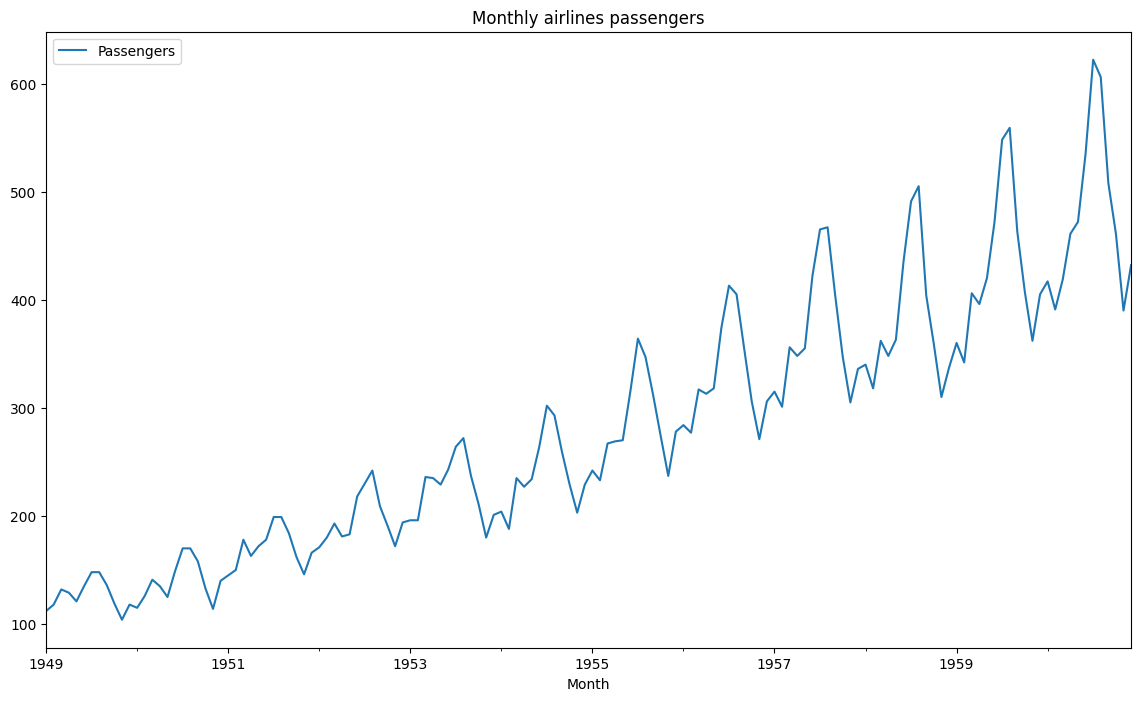

In [65]:
df.plot(figsize=(14, 8), title='Monthly airlines passengers'); # veri setini 14e8 boyutunda başlığı 'Monthly airlines passengers' olan grafiği çizdirir


In [66]:
data = df['Passengers'].values # veri setindeki yolcu sayısını alır

In [67]:
data[0:5] # ilk 5 değeri getirir

array([112., 118., 132., 129., 121.])

In [68]:
type(data[0:5]) # veri tipinin gösterimi

numpy.ndarray

In [69]:
type(data[0]) # veri tipinin gösterimi

numpy.float64

In [70]:
data.shape # veri setinin satır ve sütun sayısını gösterir

(144,)

In [71]:
data = data.reshape(-1, 1) # veri setinin satır ve sütun sayısını değiştirir

In [72]:
data.shape # kontrol

(144, 1)

In [73]:
def split_data(dataframe, test_size): # veri setini eğitim ve test olarak bölen fonskiyon / dataframe ve test için bölünme oranını argüman olarak alır
  position = int(round(len(dataframe)) * (1-test_size)) # veri setinin eğitim ve test için bölünme oranını hesaplar
  train = dataframe[:position] # eğitim verilerini alır
  test = dataframe[position:] # test verilerini alır
  return train, test, position # eğitim, test ve bölünme oranını döndürür

In [74]:
train, test, position = split_data(data, 0.33) # veri setini eğitim(0.77) ve test(0.33) olarak böler

In [75]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [76]:
scaler_train = MinMaxScaler(feature_range=(0, 1)) # eğitim için ölçekleyici oluşturur

In [77]:
train = scaler_train.fit_transform(train) # eğitim verilerini ölçeklendirir

In [78]:
scaler_test = MinMaxScaler(feature_range=(0, 1)) # test için ölçekleyici oluşturur

In [79]:
test = scaler_test.fit_transform(test) # test verilerini ölçeklendirir

In [80]:
train[0:5] # train setinin ölçeklendirilmiş ilk 5 değeri gösterir

array([[0.02588997],
       [0.04530744],
       [0.09061489],
       [0.08090615],
       [0.05501618]])

In [81]:
test[0:5] # test setinin ölçeklendirilmiş ilk 5 değeri gösterir

array([[0.04361371],
       [0.        ],
       [0.17133956],
       [0.14641745],
       [0.1682243 ]])

In [82]:
# her iterasyonda bir önceki veriye bakılmasını sağlayan fonksiyon
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)


In [83]:
lookback = 1 # her seferinde 1 ay geriye bakacağı için lookback değerimiz 1 seçiliyor

In [84]:
# Train veri seti
X_train, y_train = create_features(train, lookback)

In [85]:
# Test veri seti için
X_test, y_test = create_features(test, lookback)

In [86]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [87]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])) # X_train veri setinin satır ve sütun sayısını değiştirir
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1])) # X_test veri setinin satır ve sütun sayısını değiştirir
y_train = y_train.reshape(-1, 1) # y_train veri setinin satır ve sütun sayısını değiştirir
y_test = y_test.reshape(-1, 1) # y_test veri setinin satır ve sütun sayısını değiştirir

In [88]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


# **Modelleme(Modeling)**

In [89]:
model = Sequential() # sıralı katmanlardan oluşan bir sinir ağı modeli oluşturur

model.add(SimpleRNN(units=50, # 50 tane nöron olacak (birbiriyle etkileşimde)
                    activation='relu',
                    input_shape=(X_train.shape[1], lookback))) # sinir ağına boyut bilgisini ifade eder

model.add(Dropout(0.2)) # aşırı öğrenmeyi engellemek için 0.2 oranında nöron sönümleme
model.add(Dense(1)) # 1 tane nöron sayesinde çıktı alınacak


In [90]:
model.summary() # modelin özetini gösterir

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Optimizasyon ve Değerlendirme Metrikleinin Ayarlanması

model.compile(loss='mean_squared_error', optimizer='adam', ) # modelin derlenmesini sağlar


*  **monitor:** Modelin gelişiminni tahmin edilceği parametre
*  **patience:** Eğitimin durdurulacağı iyileşme olmayan dönemin sayısını ifade eder
*  **verbose**: verbose=0 ise ekrana bilgi basılmaz, verbose=1 olursa anlık olarak sonuç gösterir, verbose=2 her epoch sonunda bir sonuç gösterilir
*  **mode:** mode=min hatalarımızı izlediğimizde eğer azalma duruyorsa eğitim duruyor olacaktır **/** mode=max hatalarımızı izlediğimizde eğer artma duruyorsa eğitim duruyor olacaktır,

In [99]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode="min"),
             ModelCheckpoint(filepath='mymodel.h5.keras', monitor='val_loss', mode='min', # model kaydetme görevleriyle ilgili
                             save_best_only=True, save_weights_only=False, verbose=1)] # en iyi model /  modelin sadece ağırlıkları veya bütün model özelliklerini kaydetme ayarları

In [100]:
history = model.fit(x=X_train, # bağımsız değişken
                    y=y_train, # bağımlı değişken
                    epochs=50, # öğrenmenin kaç iterasyonda gerçekleşeceği
                    batch_size=1, # veri gruplarının boyutu
                    validation_data=(X_test, y_test), # hangi setlerle karşılaştırma yapılacağı
                    callbacks=callbacks,
                    shuffle=False) # optimizasyon işlemi sırasında karıştırma yapma

Epoch 1/50
90/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089
Epoch 1: val_loss improved from inf to 0.02926, saving model to mymodel.h5.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0092 - val_loss: 0.0293
Epoch 2/50
78/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223
Epoch 2: val_loss improved from 0.02926 to 0.02474, saving model to mymodel.h5.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - val_loss: 0.0247
Epoch 3/50
81/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147
Epoch 3: val_loss improved from 0.02474 to 0.02321, saving model to mymodel.h5.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0145 - val_loss: 0.0232
Epoch 4/50
93/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102
Epoch 4: val_loss improved from 0.02321 to 0.02164, saving model to mymodel.h5.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0102 - val_loss: 0.0216
Epoch 5/50
83/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061
Epoch 5: val_loss did not improve from 0.02164


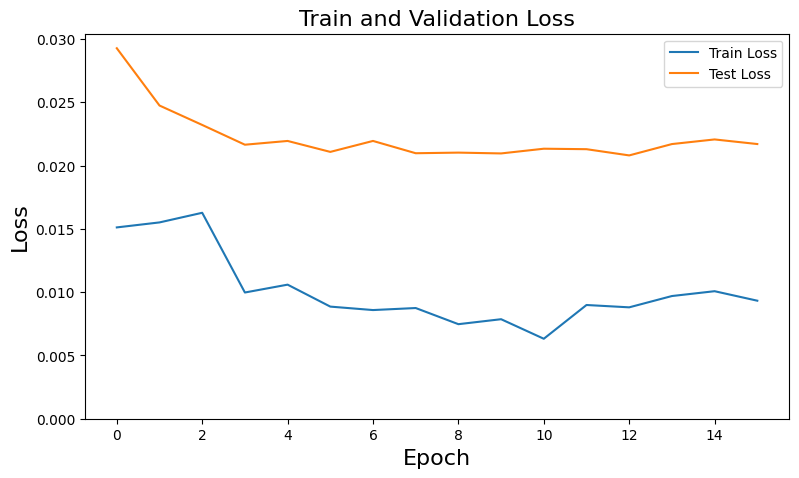

In [101]:
plt.figure(figsize=(20, 5)) # grafiğin boyutunu ayarlar
plt.subplot(1, 2, 2)  # alt grafiklerin konumunu ayarlar
plt.plot(history.history['loss'], label='Train Loss') # eğitim hatasını gösterir
plt.plot(history.history['val_loss'], label='Test Loss') # test hatasını gösterir
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Train and Validation Loss', fontsize=16);
plt.show()

# **Değerlendirme(Evaluation)**

In [103]:
loss = model.evaluate(X_test, y_test, batch_size=1) # test hatasını hesaplar
print("\nTest loss: %.1f%%" % (100.0 * loss)) # test hatasını yazdırır

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0166

Test loss: 2.2%


In [104]:
train_predict = model.predict(X_train) # eğitim verilerini tahmin eder


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [105]:
test_predict = model.predict(X_test) # test verilerini tahmin eder

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [106]:
train_predict = scaler_train.inverse_transform(train_predict) # eğitim verilerini ölçeklendirilmişten geri alır
test_predict = scaler_test.inverse_transform(test_predict) # test verilerini ölçeklendirilmişten geri alır

In [107]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))


In [108]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [114]:
print(f'Train RMSE: {train_rmse}') # eğitim verileri için RMSE değeri
print(f'Test RMSE: {test_rmse}') # test verileri için RMSE değeri

Train RMSE: 230.49879600490794
Test RMSE: 427.7887102366728


In [115]:
df.describe().T # veri setinin istatistiksel özelliklerini gösterir

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [116]:
result_df

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [117]:
train_prediction_df = result_df[lookback:position] # eğitim verilerini gösterir

In [118]:
train_prediction_df['Predicted'] = train_predict # eğitim verilerini tahmin edilen değerlerle günceller

In [119]:
train_prediction_df.head() # kontrol

,Passengers,Predicted
Month,,
1949-02-01,118.0,132.554337
1949-03-01,132.0,135.197784
1949-04-01,129.0,144.099518
1949-05-01,121.0,141.961685
1949-06-01,135.0,137.016083


In [120]:
test_prediction_df = result_df[position + lookback:] # test verilerini gösterir
test_prediction_df['Predicted'] = test_predict # test verilerini tahmin edilen değerlerle günceller
test_prediction_df.head() # kontrol

,Passengers,Predicted
Month,,
1957-02-01,301.0,333.079834
1957-03-01,356.0,328.347839
1957-04-01,348.0,366.196259
1957-05-01,355.0,358.516571
1957-06-01,422.0,365.236328


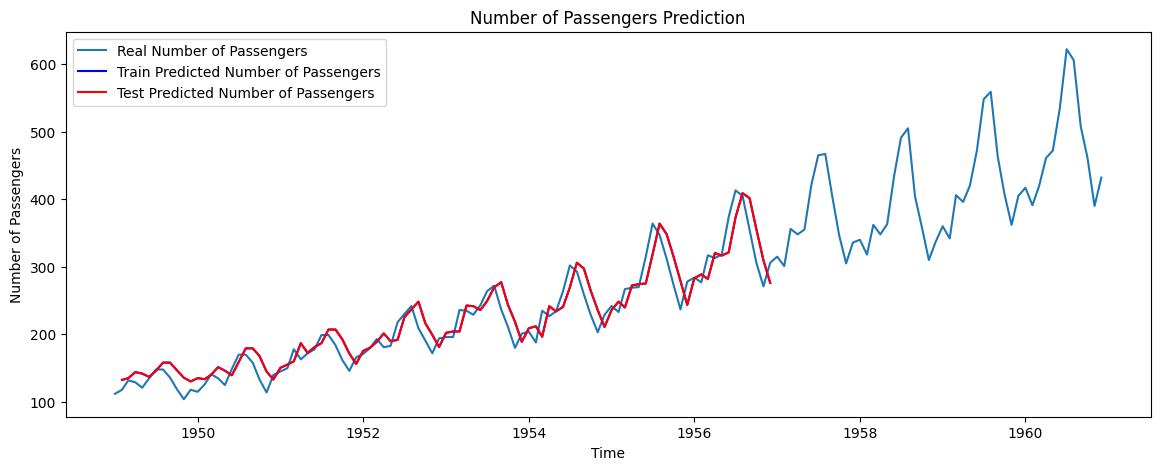

In [122]:
# Train ve Test tahminlerini ayrı ayrı görselleştirme işlemi
plt.figure(figsize=(14, 5))
plt.plot(result_df, label = 'Real Number of Passengers')
plt.plot(train_prediction_df['Predicted'], color ="blue", label = "Train Predicted Number of Passengers")
plt.plot(train_prediction_df['Predicted'], color ="red", label = "Test Predicted Number of Passengers")
plt.title("Number of Passengers Prediction")
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()